In [81]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, RepeatVector, TimeDistributed, Dense, BatchNormalization, Dropout, Attention, Concatenate
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


In [82]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# Assuming you have the dataset in a CSV file
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/datasets/translation_test.csv')

# Separate English and German sentences
english_sentences = df['english'].tolist()
german_sentences = df['german'].tolist()


In [85]:
print(df)

                                               english  \
0        A man in an orange hat starring at something.   
1    A Boston Terrier is running on lush green gras...   
2    A girl in karate uniform breaking a stick with...   
3    Five people wearing winter jackets and helmets...   
4               People are fixing the roof of a house.   
..                                                 ...   
995  Marathon runners are racing on a city street, ...   
996  Asian woman wearing a sunhat while riding a bike.   
997  Some children are outside playing in the dirt ...   
998       An older man is playing a video arcade game.   
999  A girl at the shore of a beach with a mountain...   

                                                german  
0    Ein Mann mit einem orangefarbenen Hut, der etw...  
1    Ein Boston Terrier läuft über saftig-grünes Gr...  
2    Ein Mädchen in einem Karateanzug bricht einen ...  
3    Fünf Leute in Winterjacken und mit Helmen steh...  
4              Leu

In [86]:
# Tokenize English sentences
tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(df['english'])
eng_sequences = tokenizer_eng.texts_to_sequences(df['english'])

# Tokenize German sentences
tokenizer_ger = Tokenizer()
tokenizer_ger.fit_on_texts(df['german'])
ger_sequences = tokenizer_ger.texts_to_sequences(df['german'])

In [87]:
# Pad sequences to ensure they have the same length
max_len_eng = max(len(seq) for seq in eng_sequences)
max_len_ger = max(len(seq) for seq in ger_sequences)

padded_eng_sequences = pad_sequences(eng_sequences, maxlen=max_len_eng, padding='post')
padded_ger_sequences = pad_sequences(ger_sequences, maxlen=max_len_ger, padding='post')

In [88]:
# Split the data into training and validation sets
eng_train, eng_val, ger_train, ger_val = train_test_split(
    padded_eng_sequences, padded_ger_sequences, test_size=0.2, random_state=42
)

In [89]:
# Define hyperparameters
vocab_size_eng = len(tokenizer_eng.word_index) + 1
vocab_size_ger = len(tokenizer_ger.word_index) + 1
embedding_dim = 512


In [90]:
# Encoder
encoder_inputs = Input(shape=(max_len_eng,))
encoder_embedding = Embedding(input_dim=vocab_size_eng, output_dim=embedding_dim, input_length=max_len_eng, mask_zero=True)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(256, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len_ger,))
decoder_embedding = Embedding(input_dim=vocab_size_ger, output_dim=embedding_dim, input_length=max_len_ger, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Attention mechanism
attention = Attention()([decoder_outputs, encoder_outputs])
context = Concatenate(axis=-1)([decoder_outputs, attention])

decoder_dense = Dense(vocab_size_ger, activation='softmax')
output = decoder_dense(context)



In [93]:
# Compile Model
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([eng_train, ger_train], ger_train, epochs=100, batch_size=64, validation_data=([eng_val, ger_val], ger_val))


Epoch 1/100
13/13 [==============================] - 50s 2s/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 2.4298 - val_accuracy: 0.8250
Epoch 2/100
 8/13 [=================>............] - ETA: 7s - loss: 0.0046 - accuracy: 0.9996

KeyboardInterrupt: ignored

In [94]:
# Evaluate the model
loss, accuracy = model.evaluate([eng_val, ger_val], ger_val)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

7/7 [==============================] - 2s 219ms/step - loss: 2.4981 - accuracy: 0.8263
Validation Loss: 2.4981374740600586, Validation Accuracy: 0.826256513595581


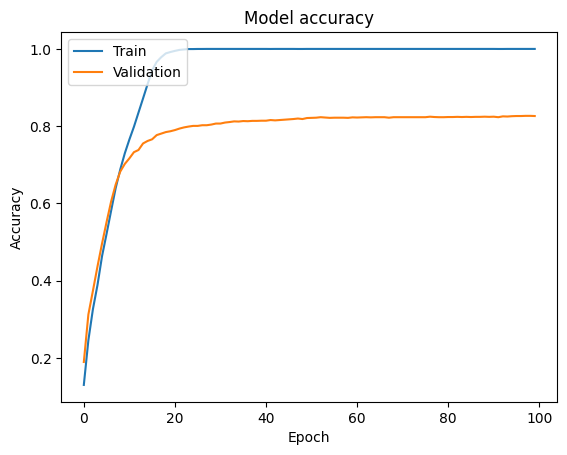

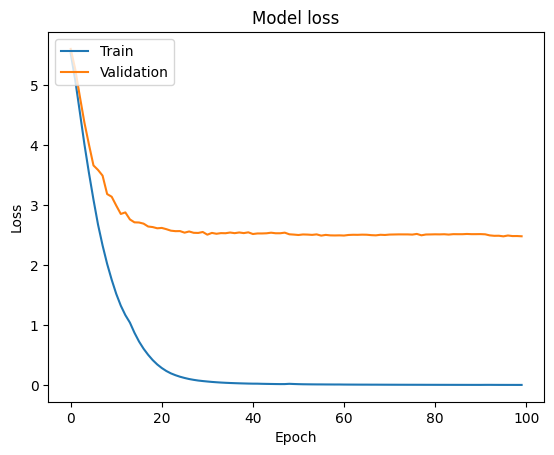

In [95]:
# Plot accuracy scores
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()